In [1]:
import numpy as np
import pandas as pd
#!pip install statsmodels
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../outputs/eci_software_2020_2023.csv', delimiter=";")
df.head()

,iso2_code,language,num_pushers,period,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca,year
0,AE,ANTLR,0,1,18,17,0,-0.29446,2.335159,0.037316,-0.330396,1.303204,0.0,2020
1,AE,ASP.NET,0,1,18,38,0,-0.29446,0.283921,0.213137,-0.330396,0.156123,0.0,2020
2,AE,Ada,0,1,18,9,0,-0.29446,2.289965,0.026459,-0.330396,0.973394,0.0,2020
3,AE,Apex,0,1,18,7,0,-0.29446,2.001467,0.031454,-0.330396,0.905917,0.0,2020
4,AE,AppleScript,0,1,18,9,0,-0.29446,2.593304,0.023655,-0.330396,1.232115,0.0,2020


In [3]:
# Checks
print(df['year'].unique())
print(df['rca'].describe())

[2020 2021 2022 2023]
count    89839.000000
mean         0.393883
std          1.062066
min          0.000000
25%          0.000000
50%          0.000000
75%          0.635488
max         93.328690
Name: rca, dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
emigration = ['GE','ME','CY','AM','KZ','AE','RS','KZ','LT','EE','UZ']

def rus_emi_other(xx):
    if xx in emigration:
        return 'Top emigration destination'
    elif xx =='RU':
        return 'Russia'
    else:
        return 'Other'

df['is_emi'] = df['iso2_code'].map(rus_emi_other)

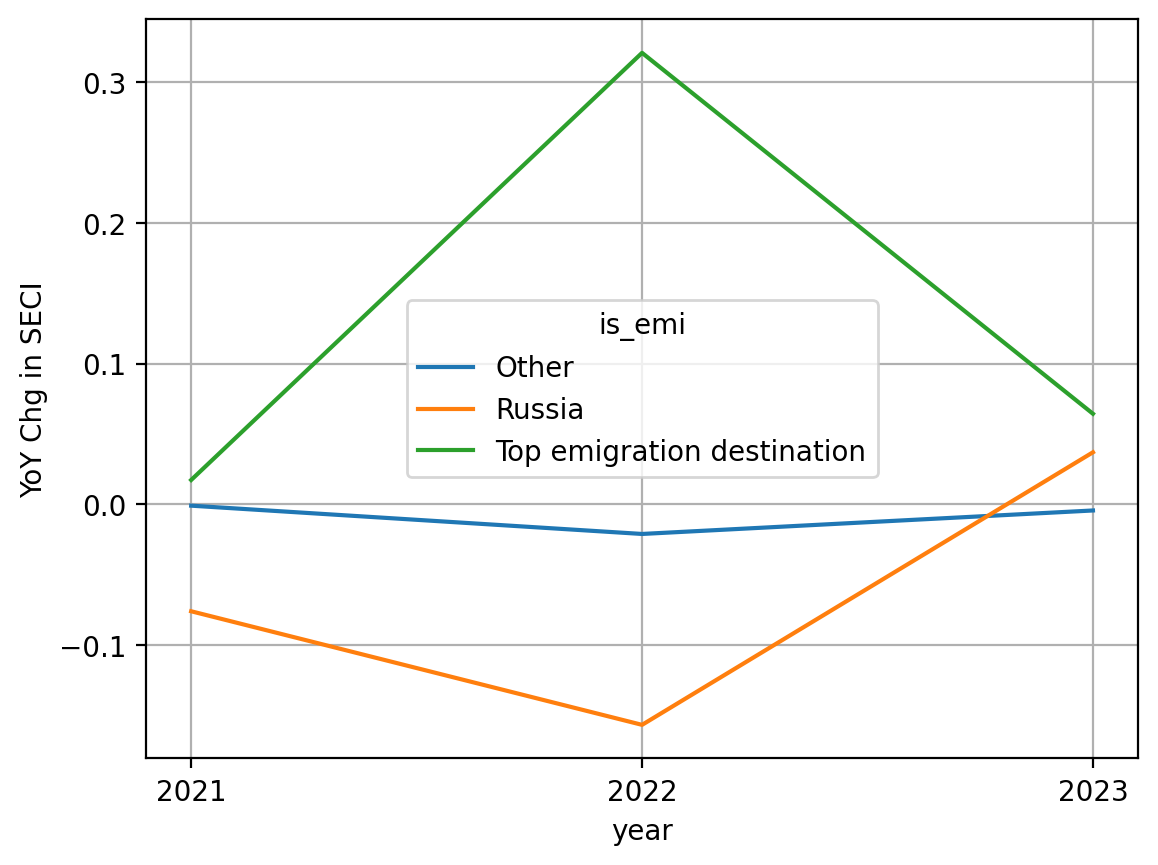

In [6]:
df.groupby(['is_emi','year'])['eci'].mean().unstack(0).diff(1).plot()
plt.xticks([2021,2022,2023])
plt.ylabel('YoY Chg in SECI')
plt.grid()

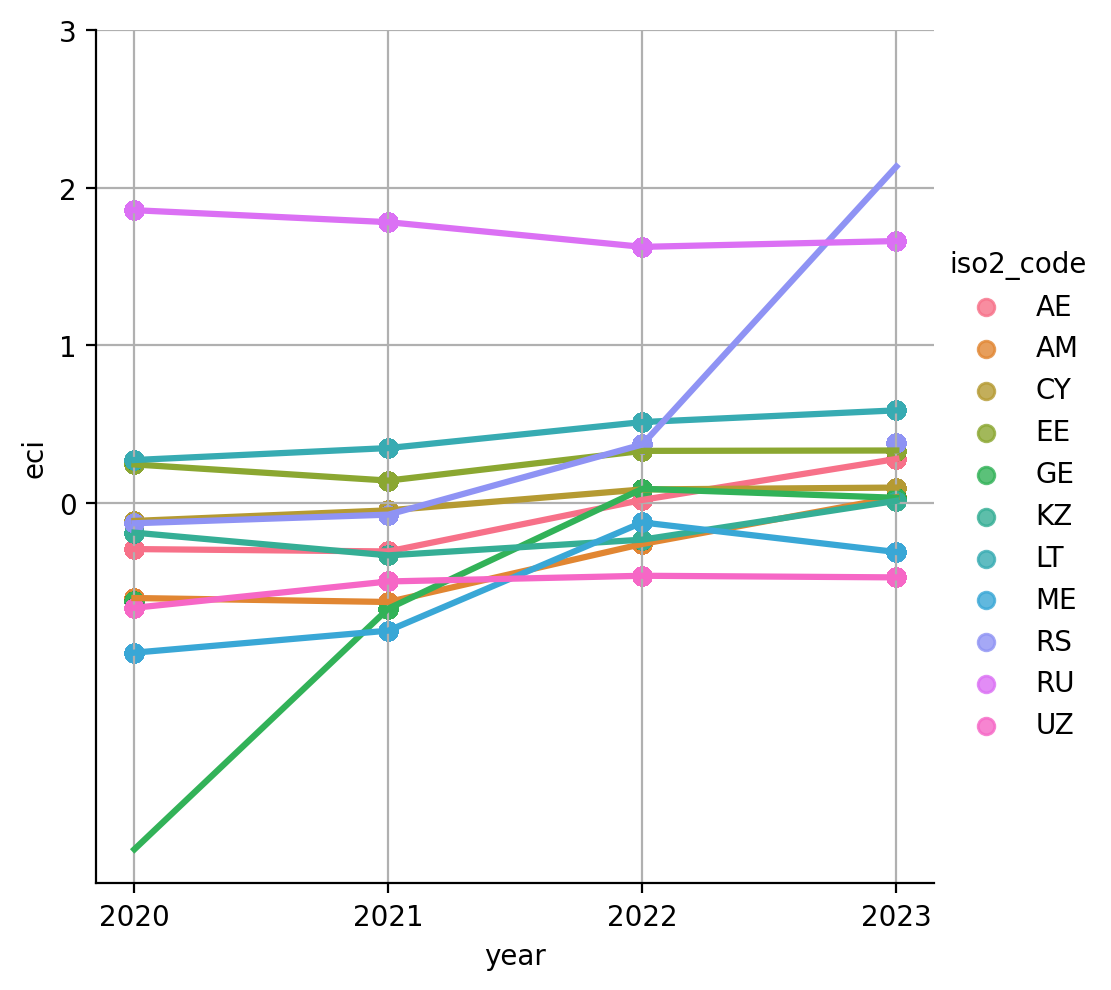

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='year', y='eci', hue='iso2_code', lowess=True,
           data=df[df['iso2_code'].isin(['RU', 'GE', 'ME', 'CY', 'AM', 'KZ', 'AE', 'RS', 'LT', 'EE', 'UZ'])],
           ci=0)
plt.xticks([2020, 2021, 2022, 2023])
plt.yticks([0, 1, 2, 3])
plt.grid()
plt.show()

# Correlations

In [8]:
# Replicating Jo's results

from scipy.stats import kendalltau
rca_vectors = df.pivot_table(index=['iso2_code', 'year'], columns='language', values='rca', fill_value=0)

def calculate_kendall_tau(russia_rca, other_rca):
    tau, p_value = kendalltau(russia_rca, other_rca)
    return tau, p_value

countries = ['GE', 'ME', 'AM', 'CY']
years = [2020, 2021, 2022, 2023]
results = []

for year in years:
    russia_rca = rca_vectors.loc[('RU', year)]
    for country in countries:
        other_rca = rca_vectors.loc[(country, year)]
        tau, _ = calculate_kendall_tau(russia_rca, other_rca)
        results.append({'year': year, 'pair': f"ru-{country.lower()}", 'kendall_tau': np.round(tau, 3)})

results_kt = pd.DataFrame(results)
results_kt

,year,pair,kendall_tau
0,2020,ru-ge,0.040
1,2020,ru-me,-0.043
2,2020,ru-am,0.041
3,2020,ru-cy,0.006
4,2021,ru-ge,0.062
5,2021,ru-me,-0.030
6,2021,ru-am,0.067
7,2021,ru-cy,0.055
8,2022,ru-ge,0.104
9,2022,ru-me,0.119


# Plot

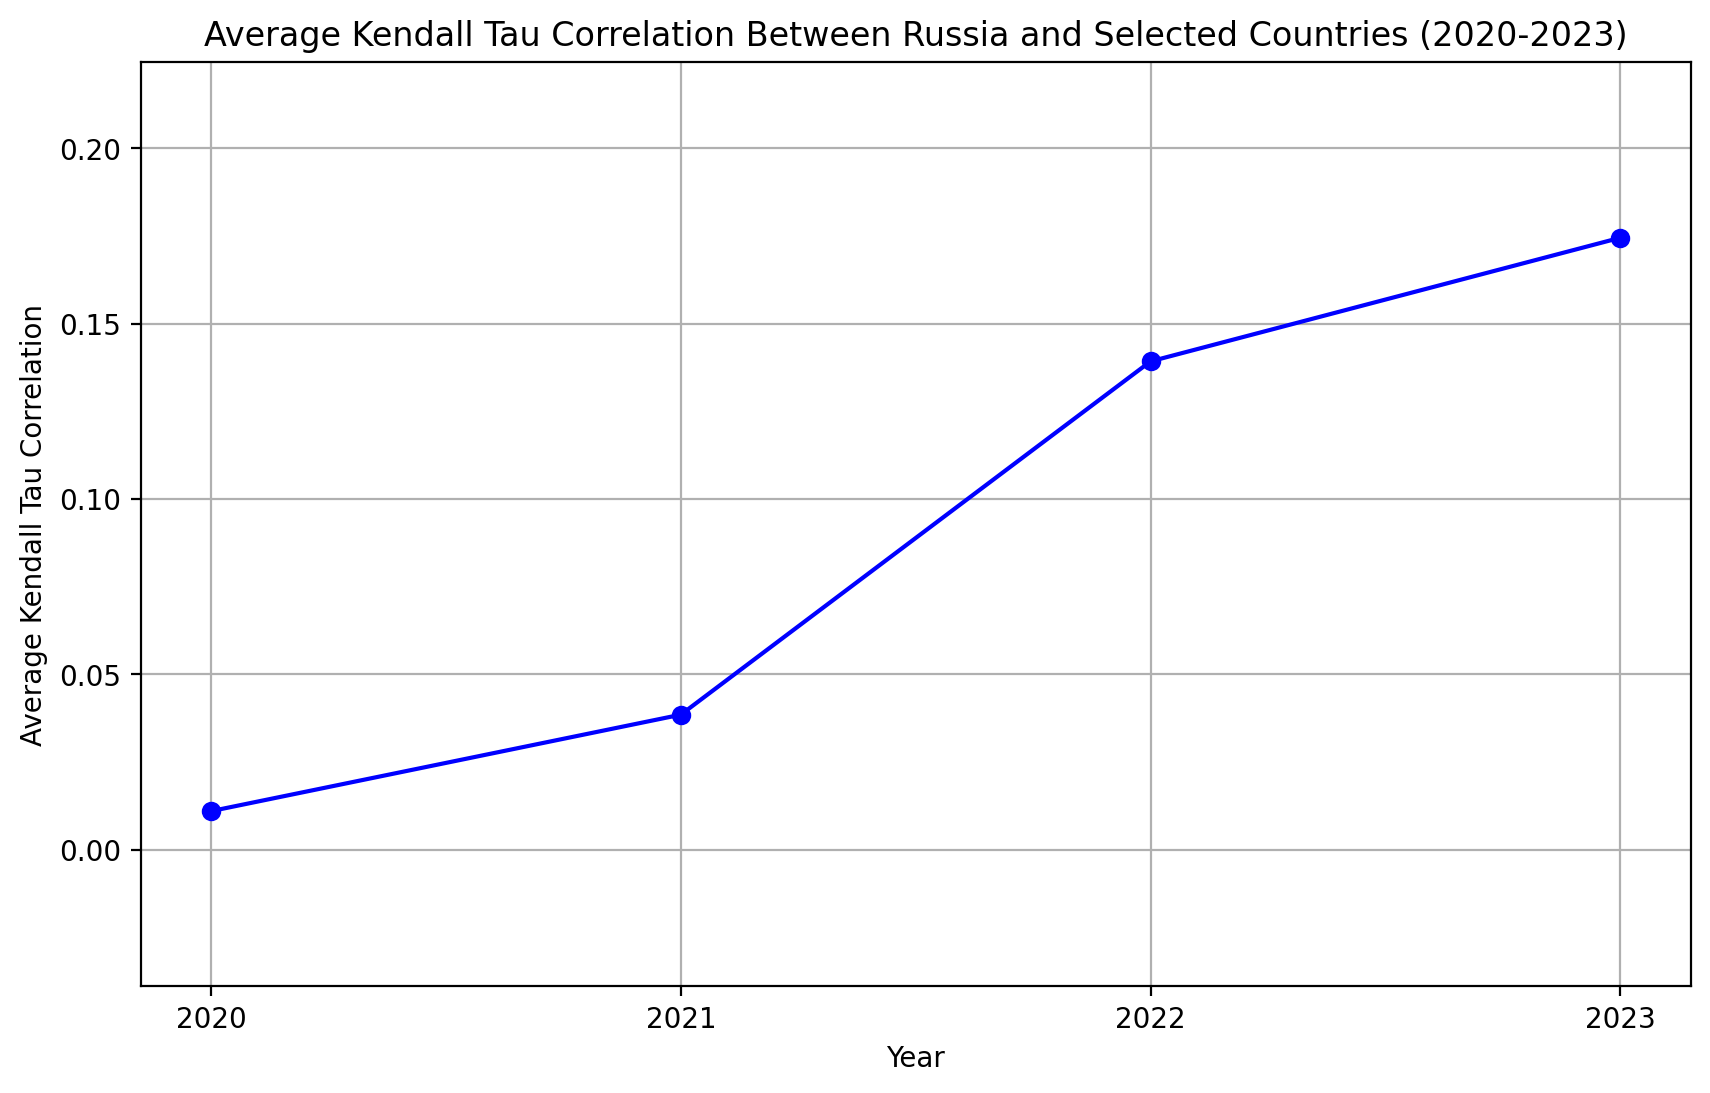

In [9]:
avg_kendall_tau = results_kt.groupby('year')['kendall_tau'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(avg_kendall_tau['year'], avg_kendall_tau['kendall_tau'], marker='o', linestyle='-', color='blue')
plt.title('Average Kendall Tau Correlation Between Russia and Selected Countries (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Average Kendall Tau Correlation')
plt.grid(True)
plt.xticks(avg_kendall_tau['year'])  # Ensure only specific years are marked
plt.ylim(min(avg_kendall_tau['kendall_tau']) - 0.05, max(avg_kendall_tau['kendall_tau']) + 0.05)  # Setting limits for better visualization
plt.show()

# Synthetic (Proximity) Control (Gathani & Stoelinga, 2013)

In [20]:
#!pip install pysyncon
from pysyncon import Dataprep, Synth

# Sandor's implementation
def minimum_conditional_prob(mcp_array1, mcp_array2):
    counter = np.sum(np.minimum(mcp_array1, mcp_array2))
    denom = max(np.sum(mcp_array1), np.sum(mcp_array2))
    return np.round(counter / denom, 3)
    
# For RCA proximity, restrict the data to the year 2020
df_2020 = df[df['year'] == 2020]
rca_vectors_2020 = df_2020.pivot_table(index='iso2_code', columns='language', values='rca', fill_value=0)

# Cutoff like Gathani & Stoelinga, 2013
rca_vectors_2020 = rca_vectors_2020.apply(lambda x: x.map(lambda y: 1 if y > 1 else 0))

# Compute the similarity between Russia and all other countries
russia_vector = rca_vectors_2020.loc['RU'].values
similarity_scores = {country: minimum_conditional_prob(russia_vector, vector.values)
                     for country, vector in rca_vectors_2020.iterrows() if country != 'RU'}

# Find the three highest matching countries
top_3_matches = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)[:3]
synthetic_control_countries = [country for country, score in top_3_matches]
print(f"Synthetic Control Countries: {synthetic_control_countries}")

# df with synthetic control countries and Russia only
countries_of_interest = synthetic_control_countries + ['RU']
eci_filtered = df[df['iso2_code'].isin(countries_of_interest) & df['year'].isin([2020, 2021, 2022, 2023])]

# Averaging ECI values for each iso2_code, year, and period (all periods are "1" right now, just in case we can make quarterly)
eci_filtered = eci_filtered.groupby(['iso2_code', 'year', 'period'], as_index=False)['eci'].mean()

# Initialize the Dataprep object
dataprep = Dataprep(
    foo=eci_filtered,
    predictors=["eci"],
    predictors_op="mean",
    time_predictors_prior=range(2020, 2021),
    special_predictors=[],
    dependent="eci",
    unit_variable="iso2_code",
    time_variable="year",
    treatment_identifier="RU",
    controls_identifier=synthetic_control_countries,
    time_optimize_ssr=range(2020, 2021)
)

# Initialize and fit the Synthetic Control model
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="BFGS", optim_initial="ols")

# Get the weights
weights = synth.weights(threshold=0.01)
print(weights)

Synthetic Control Countries: ['PL', 'FR', 'NL']
PL    0.698
FR    0.093
NL    0.210
Name: weights, dtype: float64


/Users/jermainkaminski/.virtualenvs/github-complexity/lib/python3.11/site-packages/pysyncon/dataprep.py:277: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X1 = pd.concat([X1_nonspecial, X1_special], axis=0)


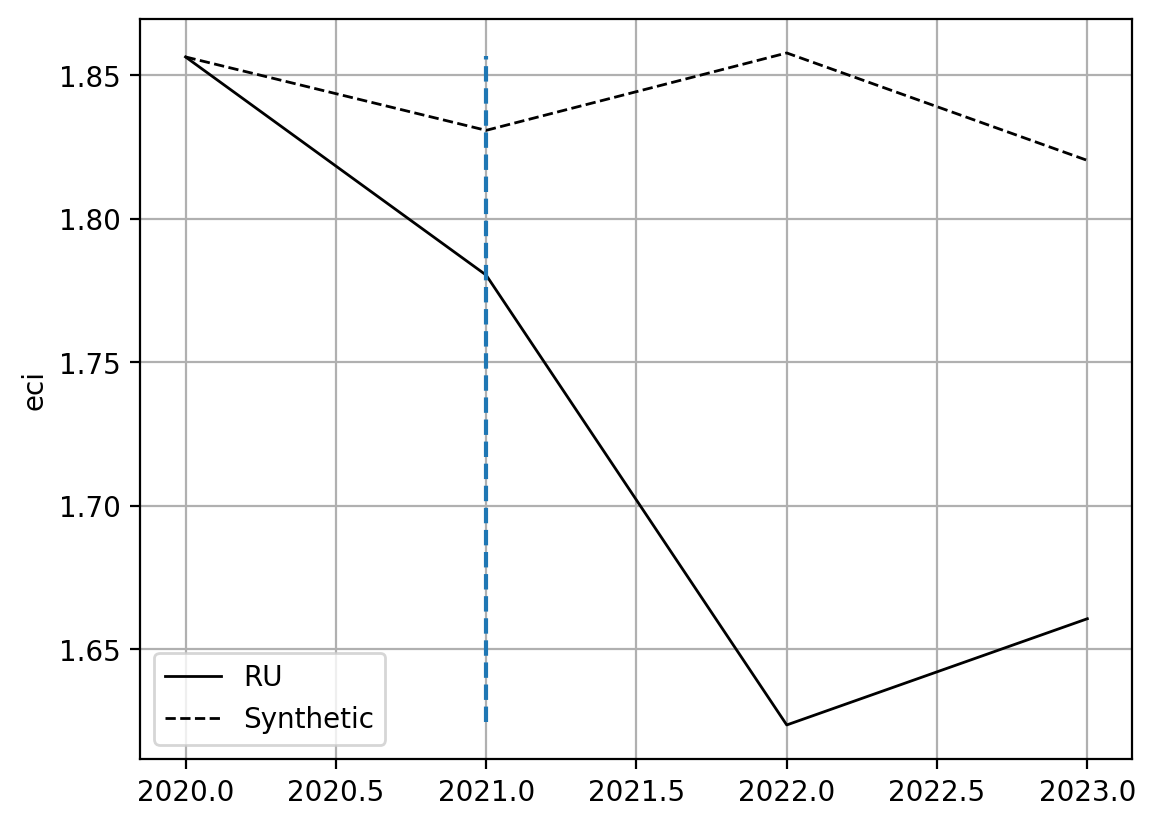

In [21]:
synth.path_plot(time_period=range(2020, 2024), treatment_time=2021)

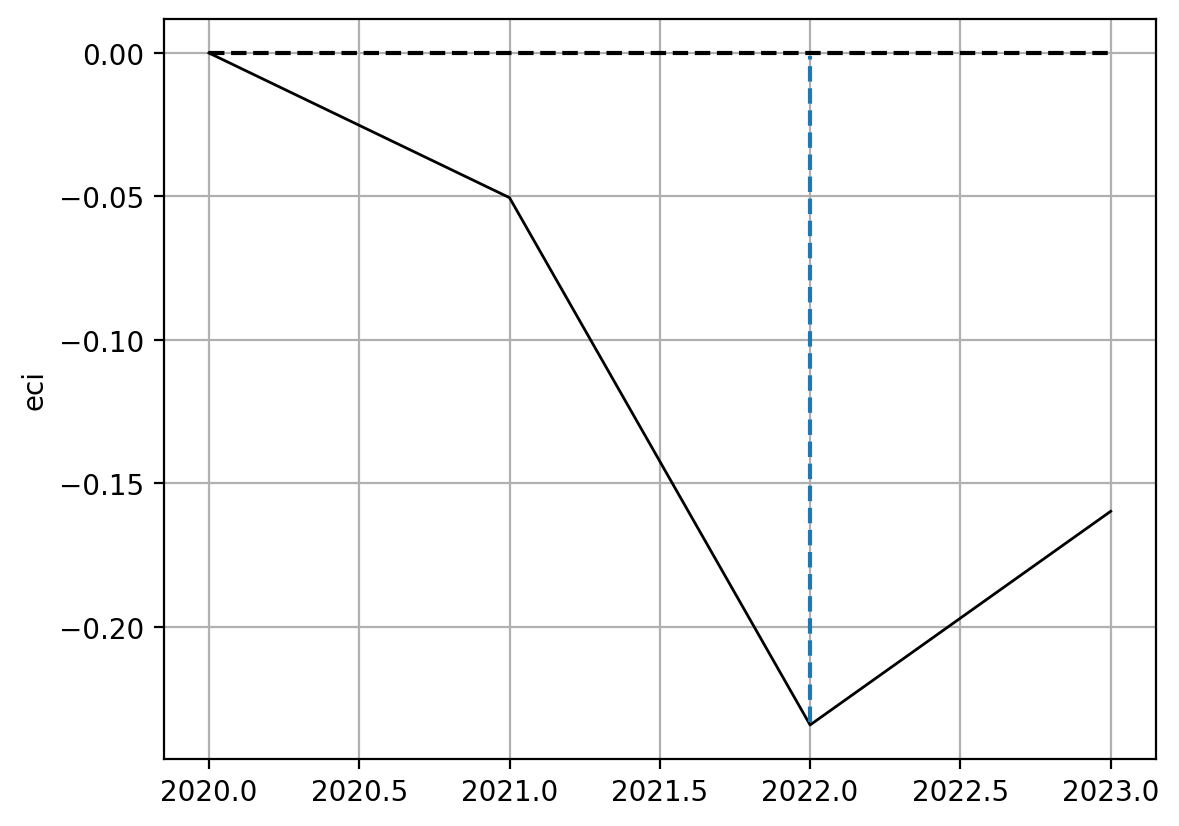

In [22]:
synth.gaps_plot(time_period=range(2020, 2024), treatment_time=2022)

In [23]:
# Average treatment effect on the treated unit (ATT) over the post-treatment time period
display(synth.att(time_period=range(2020, 2024)))

# Summary / ignore error
display(synth.summary())

{'att': -0.11108263566157939, 'se': 0.052865156486595496}

/Users/jermainkaminski/.virtualenvs/github-complexity/lib/python3.11/site-packages/pysyncon/dataprep.py:277: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X1 = pd.concat([X1_nonspecial, X1_special], axis=0)


,V,treated,synthetic,sample mean
eci,1.0,1.856,1.856,1.903


In [31]:
# Confidence intervals
synth.confidence_interval(
    alpha=0.05,
    time_periods=[2020, 2021, 2022, 2023],
    custom_V=synth.V,
    tol=0.01,
    verbose=False,
)

/Users/jermainkaminski/.virtualenvs/github-complexity/lib/python3.11/site-packages/pysyncon/dataprep.py:277: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X1 = pd.concat([X1_nonspecial, X1_special], axis=0)


ValueError: Too few pre-intervention time-periods available for significance level `alpha`=0.05, either increase `alpha` or use more pre-intervention time-periods.